# ライブラリ

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# データ読み込み

In [2]:
df = pd.read_csv('../processing_data/merged.csv', encoding='shift_jis')

- 外れ値削除

In [3]:
df[df['売上'] > 300000]

,日付,店舗ID,商品ID,商品価格,売上個数,売上,商品カテゴリID,商品カテゴリ名,商品カテゴリ,商品名,曜日,年,月,日,四半期,週,平日/休日
312757,2018-06-14,6,1300239,4350,107,465450,130,ゲーム - ゲーム機C,ゲーム,ゲーム機C,Thursday,2018,6,14,2,24,0
312889,2018-06-14,13,1300239,4300,80,344000,130,ゲーム - ゲーム機C,ゲーム,ゲーム機C,Thursday,2018,6,14,2,24,0
312951,2018-06-14,6,1300239,4310,76,327560,130,ゲーム - ゲーム機C,ゲーム,ゲーム機C,Thursday,2018,6,14,2,24,0
313014,2018-06-14,7,1300239,4320,77,332640,130,ゲーム - ゲーム機C,ゲーム,ゲーム機C,Thursday,2018,6,14,2,24,0
632513,2018-12-13,12,1900119,523570,1,523570,190,PCソフト - PCソフト,PCソフト,PCソフト,Thursday,2018,12,13,4,50,0


In [4]:
# '商品価格'列が500,000以上の行を削除
df = df[df['商品価格'] < 500000]

# EDA

- 値段の振れ幅によってグルーピング<br>
  ①値段が下がっている<br>
  ②値段が一定<br>
  ③値段が上がっている<br>

In [5]:
df['商品カテゴリID'].nunique()

26

- 商品ID

In [6]:
df['商品ID'].nunique()

9039

同一商品IDの統計量を確認する

統計量でグルーピングしてみる
値段に振れ幅が出ている * 売上個数が多い商品を打っている店は売り上げ下がっている？
商品ID内でグルーピングしてみる

In [8]:
# 商品IDごとに統計情報を計算
product_stats = df.groupby('商品ID').agg({
    '売上': ['mean', 'std'],
    '売上個数': ['mean', 'std'],
    '商品価格': ['mean', 'std'],
}).reset_index()

# 列の階層を平らにする
product_stats.columns = [f"{col[0]}_{col[1]}" for col in product_stats.columns]

# 欠損値の処理
product_stats = product_stats.fillna(product_stats.mean())

# 標準化
scaler = StandardScaler()
scaled_stats = scaler.fit_transform(product_stats)

# クラスタリングの実施
num_clusters = 7  # クラスタの数
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
product_stats['GoodsCluster'] = kmeans.fit_predict(scaled_stats)

# 商品ID列名前変更
product_stats = product_stats.rename(columns={'商品ID_':'商品ID'})

product_stats

c:\Users\104161\Anaconda3\envs\py310_analysis\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,商品ID,売上_mean,売上_std,売上個数_mean,売上個数_std,商品価格_mean,商品価格_std,GoodsCluster
0,1000001,386.423729,121.427237,1.052542,0.245057,367.813559,80.645523,0
1,1000002,237.800000,44.905996,1.003333,0.057735,236.966667,42.266065,0
2,1000003,231.619718,44.413232,1.014085,0.118257,228.661972,37.401955,0
3,1000004,224.025157,42.218832,1.000000,0.000000,224.025157,42.218832,0
4,1000005,244.555556,37.776977,0.997222,0.117982,245.250000,23.742907,0
...,...,...,...,...,...,...,...,...
9034,3500069,420.000000,0.000000,1.000000,0.000000,420.000000,0.000000,5
9035,3500070,389.000000,74.304180,1.000000,0.000000,389.000000,74.304180,5
9036,3500071,590.000000,322.946585,1.000000,0.176968,590.000000,118.270471,5
9037,3500072,420.000000,0.000000,1.000000,0.000000,420.000000,0.000000,5


In [9]:
temp = product_stats[['商品ID', 'GoodsCluster']]

In [10]:
# 商品IDごとに統計情報とクラスタリング結果を元のデータフレームに結合
merged_df = pd.merge(df, temp, on='商品ID', how='left')

# 結合結果の表示
merged_df

,日付,店舗ID,商品ID,商品価格,売上個数,売上,商品カテゴリID,商品カテゴリ名,商品カテゴリ,商品名,曜日,年,月,日,四半期,週,平日/休日,GoodsCluster
0,2018-01-01,6,1000001,420,1,420,100,映画 - DVD,映画,DVD,Monday,2018,1,1,1,1,0,0
1,2018-01-01,1,3100018,1950,1,1950,310,ゲーム - 付属品(購入特典),ゲーム,付属品(購入特典),Monday,2018,1,1,1,1,0,5
2,2018-01-01,7,2200016,510,1,510,220,ゲーム - ゲーム機A,ゲーム,ゲーム機A,Monday,2018,1,1,1,1,0,5
3,2018-01-01,10,2400001,2850,1,2850,240,ギフト - ボードゲーム,ギフト,ボードゲーム,Monday,2018,1,1,1,1,0,5
4,2018-01-01,15,1500067,3230,1,3230,150,ゲーム - ゲーム機B,ゲーム,ゲーム機B,Monday,2018,1,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1119564,2019-10-31,7,1100443,1020,2,2040,110,PCゲーム - 通常版,PCゲーム,通常版,Thursday,2019,10,31,4,44,0,0
1119565,2019-10-31,7,1100443,1020,1,1020,110,PCゲーム - 通常版,PCゲーム,通常版,Thursday,2019,10,31,4,44,0,0
1119566,2019-10-31,8,1600060,1020,1,1020,160,ギフト - 小型ゲーム,ギフト,小型ゲーム,Thursday,2019,10,31,4,44,0,0
1119567,2019-10-31,3,1002540,680,1,680,100,映画 - DVD,映画,DVD,Thursday,2019,10,31,4,44,0,0


- クラスタリング結果可視化

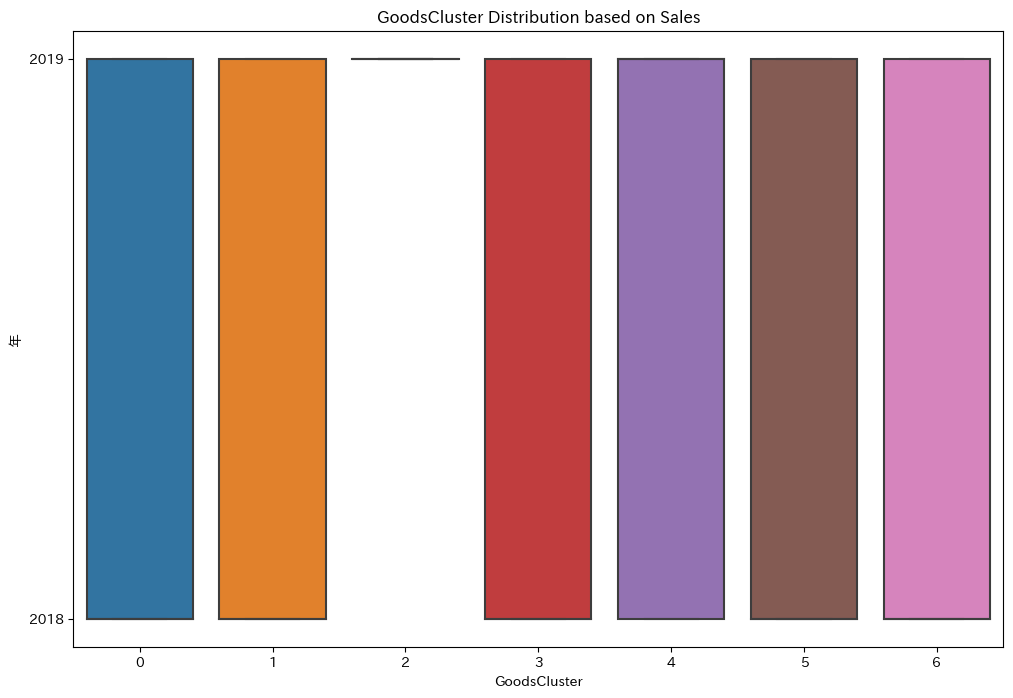

In [21]:
# 商品IDの統計量でクラスタリングしたGoodsClusterの分布を可視化
target = '年'

plt.figure(figsize=(12, 8))
sns.boxplot(x='GoodsCluster', y=target, data=merged_df)
plt.title('GoodsCluster Distribution based on Sales')

# # y軸の表示範囲を設定
plt.yticks(range(2018, 2020))


plt.show()

- 曜日のみ

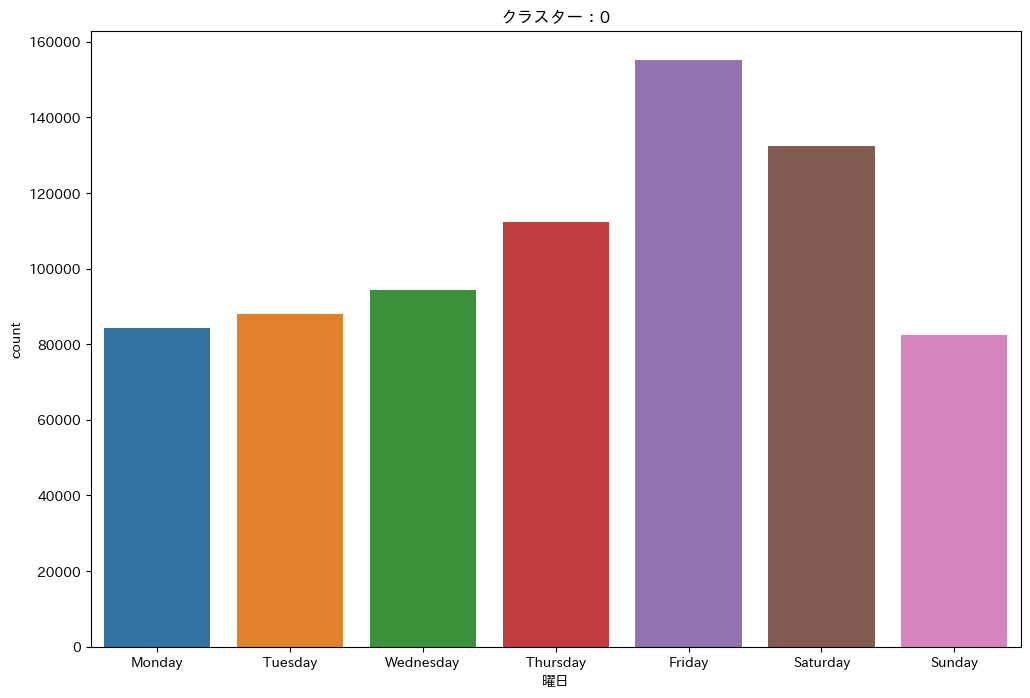

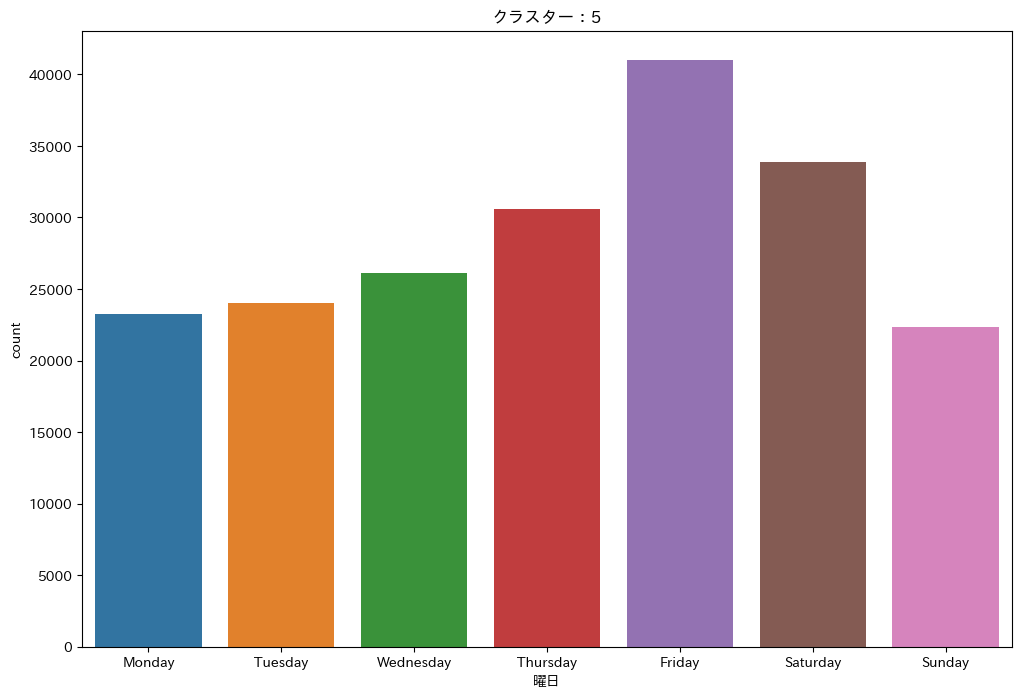

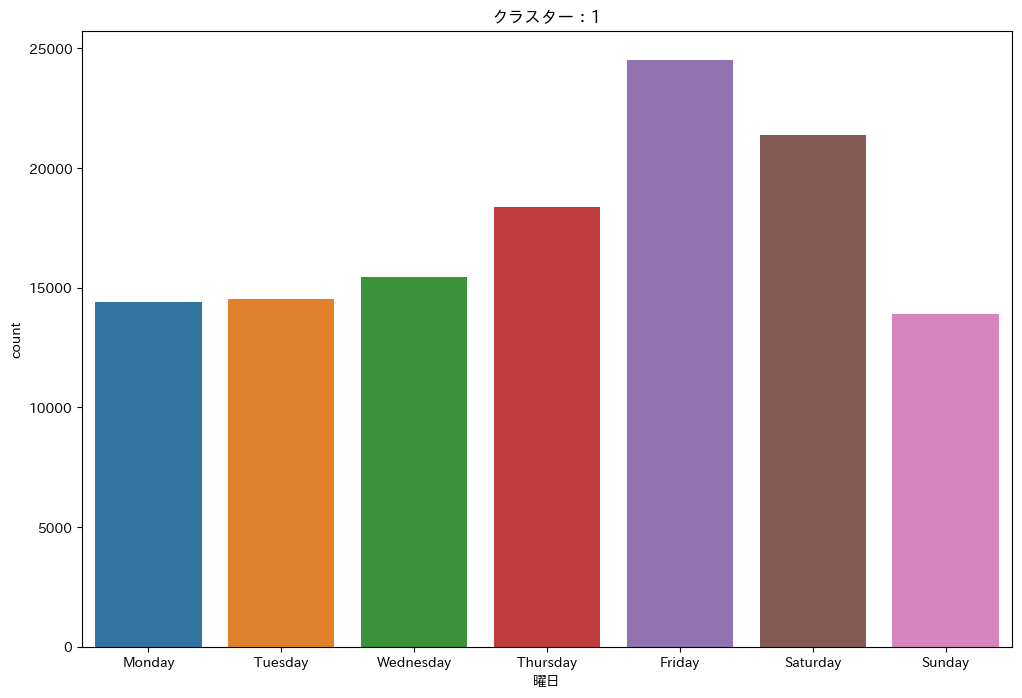

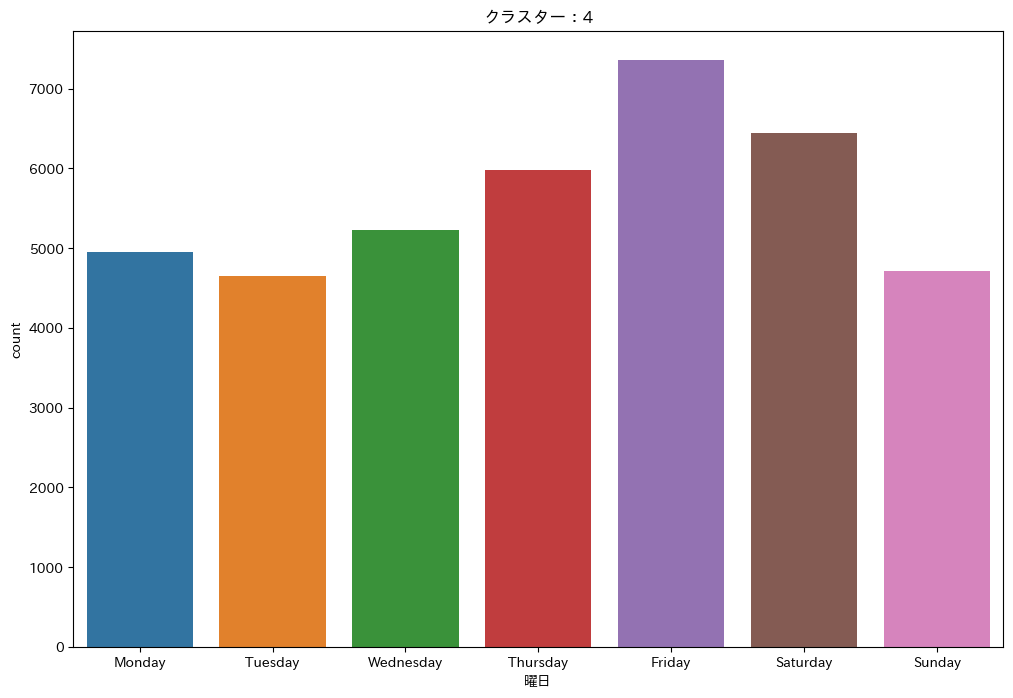

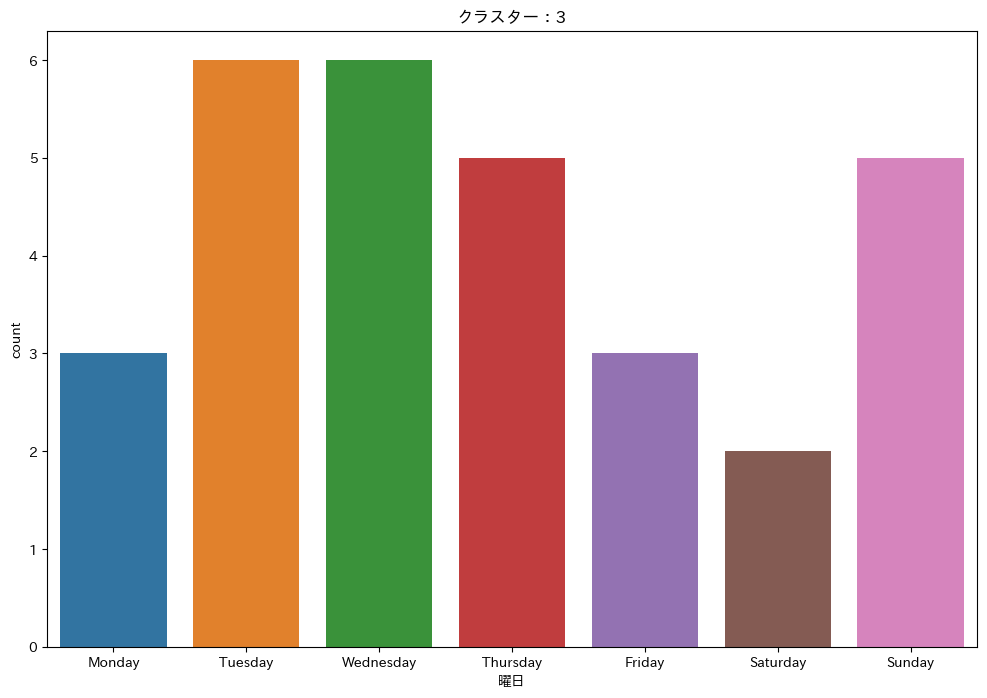

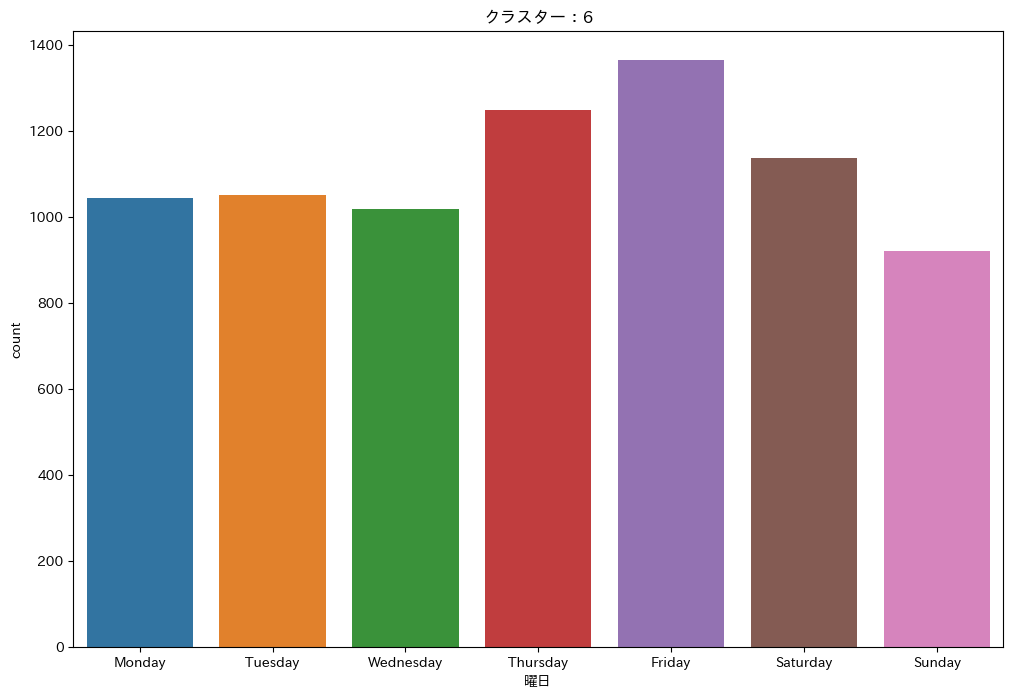

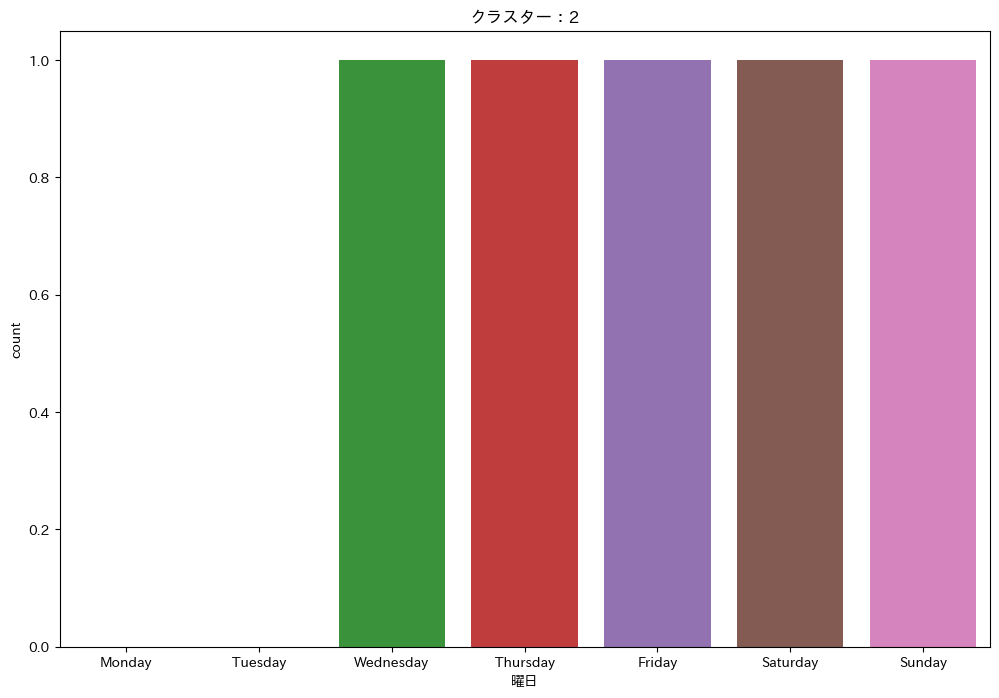

In [30]:
# 曜日の順序を指定
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# 商品IDの統計量でクラスタリングしたGoodsClusterの一覧を取得
cluster_list = merged_df['GoodsCluster'].unique()

target = '曜日'

# 指定されたGoodsClusterごとに曜日の分布を可視化
for specified_cluster in cluster_list:
    # 指定されたGoodsClusterに対応するデータを抽出
    cluster_data = merged_df[merged_df['GoodsCluster'] == specified_cluster]

    # 商品IDの統計量でクラスタリングしたGoodsClusterの分布を可視化
    plt.figure(figsize=(12, 8))
    sns.countplot(x=target, data=cluster_data, order=weekday_order)
    plt.title(f'クラスター：{specified_cluster}')
    plt.show()

- 曜日以外

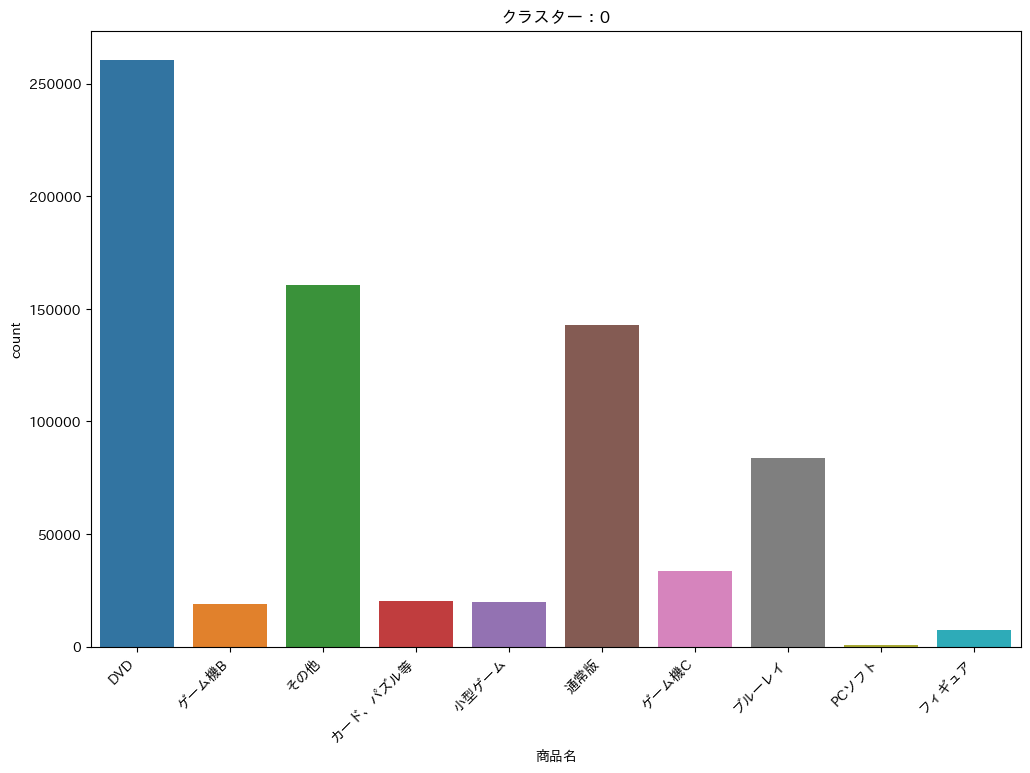

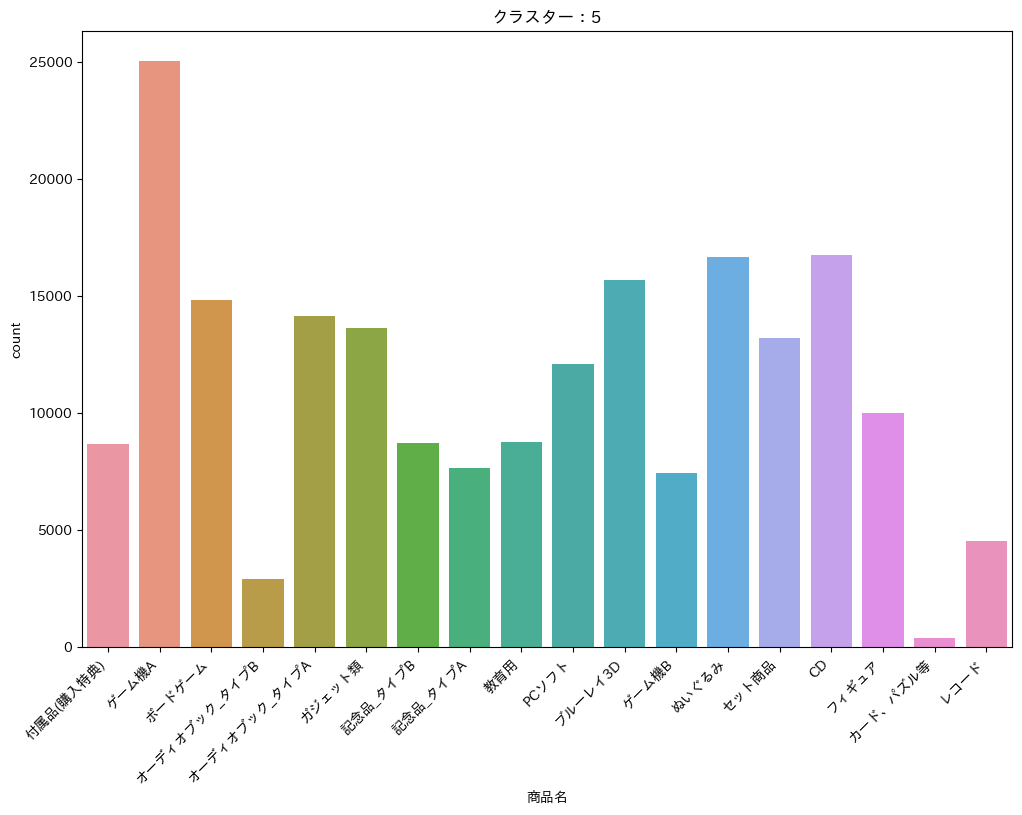

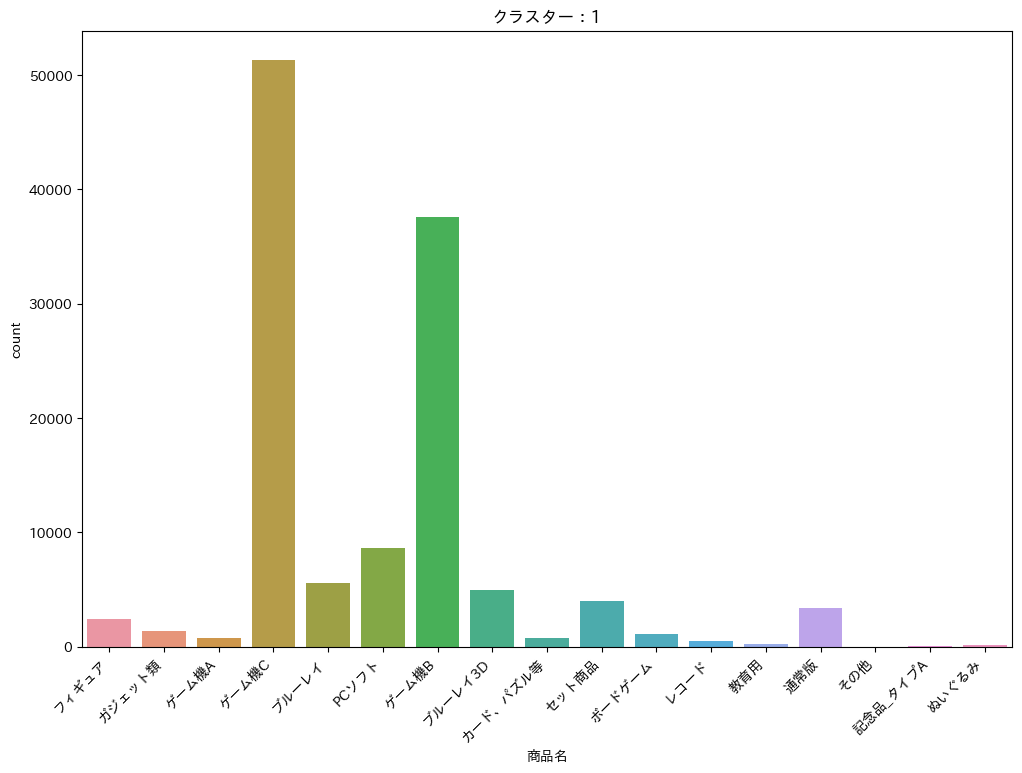

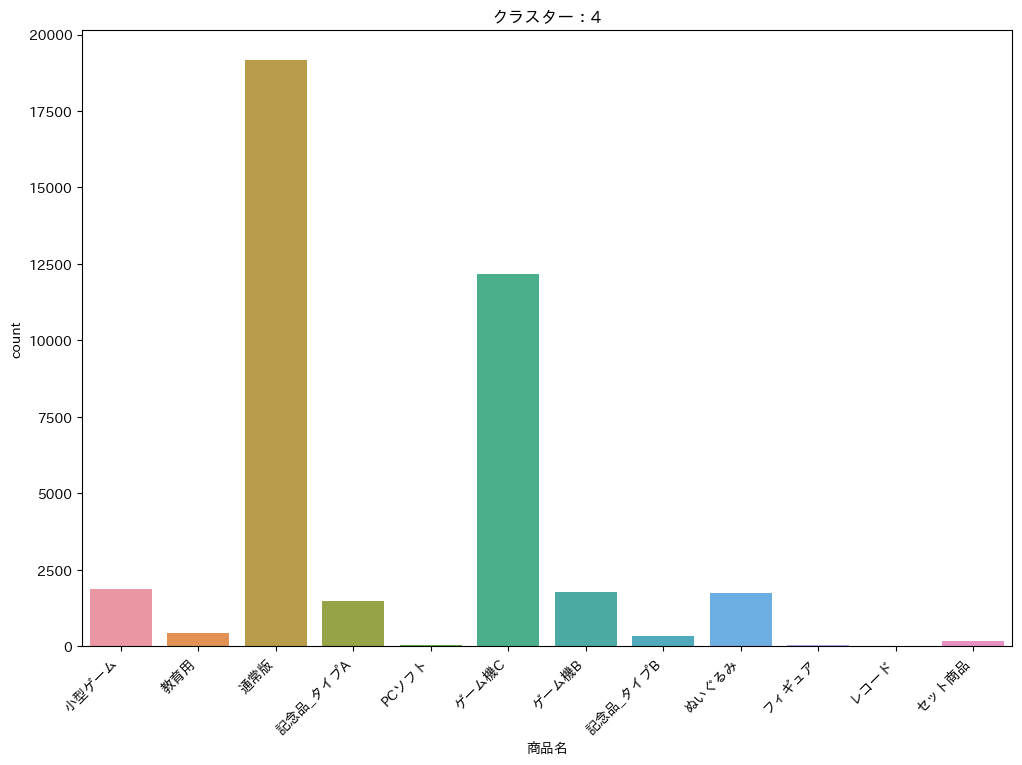

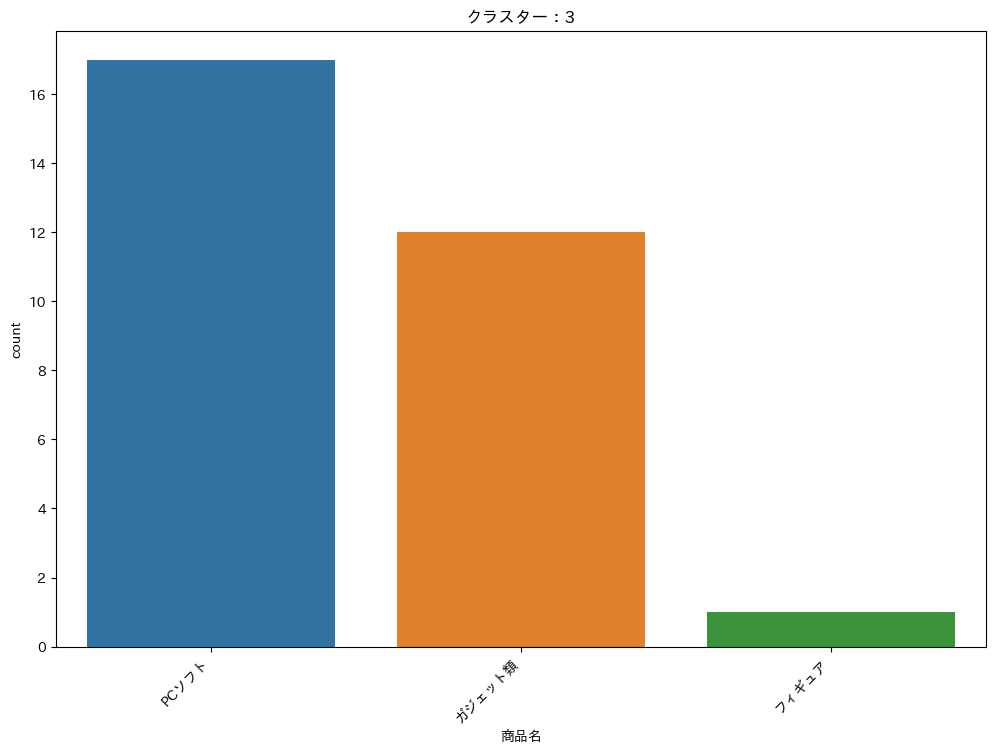

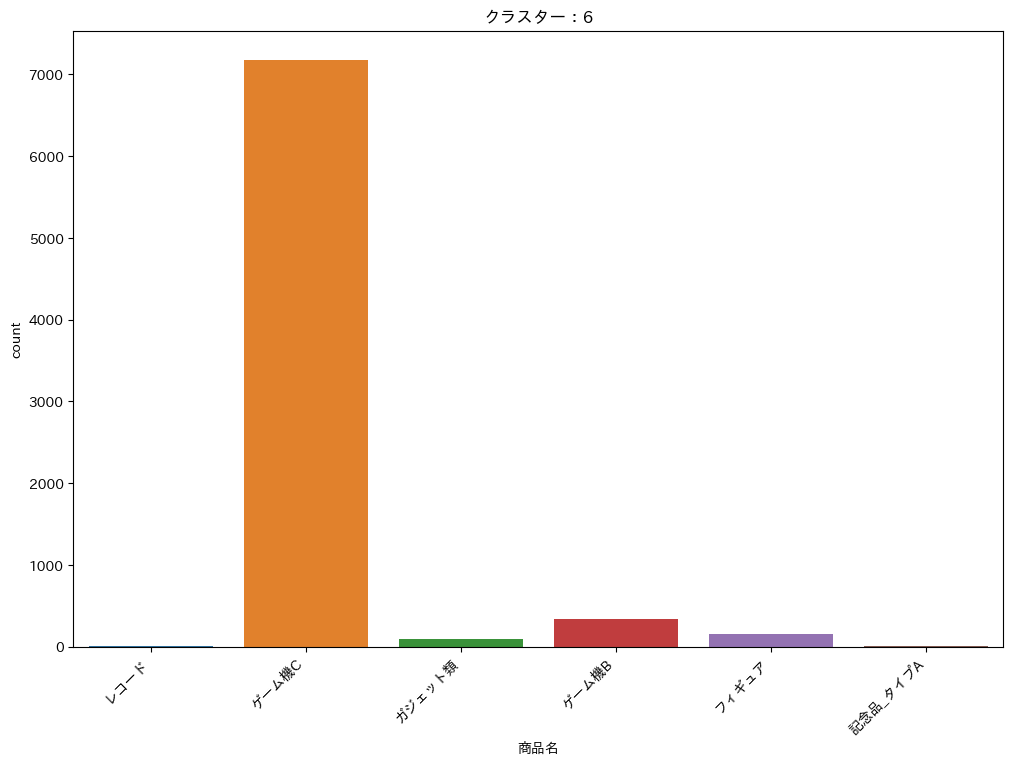

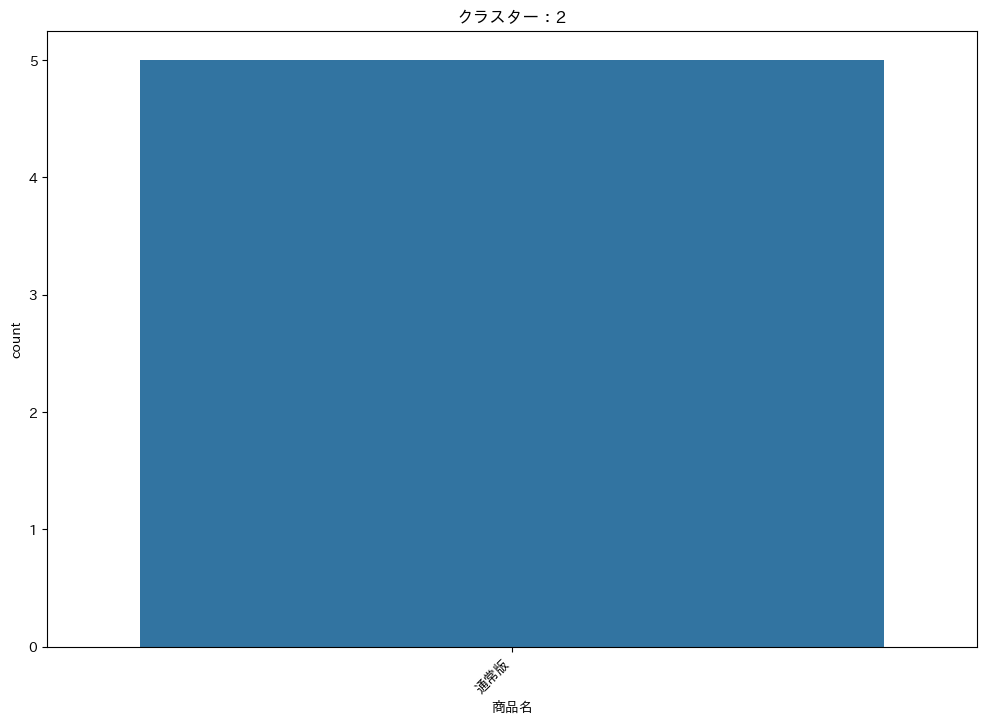

In [26]:
target = '商品名'

# 商品IDの統計量でクラスタリングしたGoodsClusterの一覧を取得
cluster_list = merged_df['GoodsCluster'].unique()

# 指定されたGoodsClusterごとに商品カテゴリIDの分布を可視化
for specified_cluster in cluster_list:
    # 指定されたGoodsClusterに対応するデータを抽出
    cluster_data = merged_df[merged_df['GoodsCluster'] == specified_cluster]

    # 商品IDの統計量でクラスタリングしたGoodsClusterの分布を可視化
    plt.figure(figsize=(12, 8))
    sns.countplot(x=target, data=cluster_data)
    plt.title(f'クラスター：{specified_cluster}')
    # x軸のラベルを45度傾けて表示
    plt.xticks(rotation=45, ha='right')
    plt.show()

In [14]:
merged_df[merged_df['GoodsCluster']==3]

,日付,店舗ID,商品ID,商品価格,売上個数,売上,商品カテゴリID,商品カテゴリ名,商品カテゴリ,商品名,曜日,年,月,日,四半期,週,平日/休日,GoodsCluster
59419,2018-01-30,6,1900026,56080,1,56080,190,PCソフト - PCソフト,PCソフト,PCソフト,Tuesday,2018,1,30,1,5,0,3
152795,2018-03-15,6,1900026,56080,1,56080,190,PCソフト - PCソフト,PCソフト,PCソフト,Thursday,2018,3,15,1,11,0,3
228130,2018-04-25,12,1900068,50490,1,50490,190,PCソフト - PCソフト,PCソフト,PCソフト,Wednesday,2018,4,25,2,17,0,3
284621,2018-05-30,4,1900077,42330,1,42330,190,PCソフト - PCソフト,PCソフト,PCソフト,Wednesday,2018,5,30,2,22,0,3
350354,2018-07-05,4,1900026,56080,1,56080,190,PCソフト - PCソフト,PCソフト,PCソフト,Thursday,2018,7,5,3,27,0,3
444286,2018-08-25,14,1900095,37380,1,37380,190,PCソフト - PCソフト,PCソフト,PCソフト,Saturday,2018,8,25,3,34,1,3
475640,2018-09-11,12,1900100,62880,1,62880,190,PCソフト - PCソフト,PCソフト,PCソフト,Tuesday,2018,9,11,3,37,0,3
507764,2018-09-30,13,1900100,55140,1,55140,190,PCソフト - PCソフト,PCソフト,PCソフト,Sunday,2018,9,30,3,39,1,3
513708,2018-10-05,6,2600142,30600,1,30600,260,ギフト - ガジェット類,ギフト,ガジェット類,Friday,2018,10,5,4,40,0,3
545571,2018-10-24,12,1900109,71400,1,71400,190,PCソフト - PCソフト,PCソフト,PCソフト,Wednesday,2018,10,24,4,43,0,3


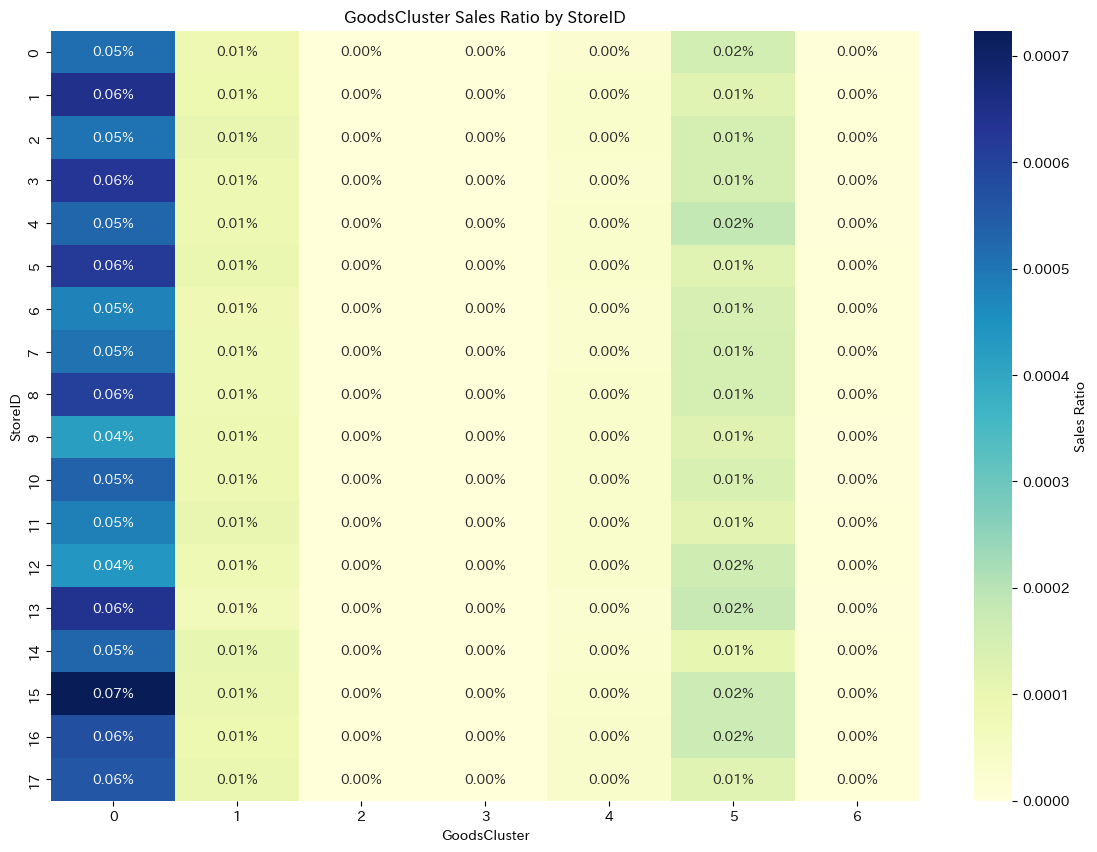

In [33]:
# 店舗IDごとにGoodsClusterの販売数と総販売数を計算
store_cluster_counts = merged_df.groupby(['店舗ID', 'GoodsCluster']).size().unstack(fill_value=0)
store_total_sales = merged_df.groupby('店舗ID')['売上個数'].sum()

# GoodsClusterの販売比率を計算
store_cluster_ratios = store_cluster_counts.div(store_total_sales, axis=0)

# ヒートマップの作成
plt.figure(figsize=(14, 10))
sns.heatmap(store_cluster_ratios, annot=True, cmap='YlGnBu', fmt='.2%', cbar_kws={'label': 'Sales Ratio'})
plt.title('GoodsCluster Sales Ratio by StoreID')
plt.xlabel('GoodsCluster')
plt.ylabel('StoreID')
plt.show()